In [1]:
import os
import pandas as pd
import h5py
import numpy as np
import shutil

In [10]:
train_pathes_full = {}

for root, dirs, files in os.walk("Train_9G/Train"):
    for file in files:
        train_pathes_full[os.path.join(root, file)] = os.path.join(root, file).split('/')[1].lower()

In [3]:
train_pathes_full

{'.train/dining_room/00000743.jpg': 'dining_room',
 '.train/dining_room/00003761.jpg': 'dining_room',
 '.train/dining_room/gsun_2f52200a449cceb17f85f4f0477b065f.jpg': 'dining_room',
 '.train/dining_room/gsun_e495af39dcbe23b8b6e69c453db2df27.jpg': 'dining_room',
 '.train/dining_room/gsun_a5e1fdfb90dba0e99f01c24d96489702.jpg': 'dining_room',
 '.train/dining_room/gsun_f3b96bc89fedc76b2c5ca5610d1fbeac.jpg': 'dining_room',
 '.train/dining_room/gsun_c13d7110c2c210fd164497e5a01e6ba3.jpg': 'dining_room',
 '.train/dining_room/gsun_cd681b1f1e3680133f652dfd5e7cfccb.jpg': 'dining_room',
 '.train/dining_room/gsun_b299d35888e5677aa5358fb84173b5d0.jpg': 'dining_room',
 '.train/dining_room/00001235.jpg': 'dining_room',
 '.train/dining_room/gsun_1b42f9bbee0f0e39803c47c8d1b99f0e.jpg': 'dining_room',
 '.train/dining_room/gsun_beeea16743ea49de434e348a04bc215e.jpg': 'dining_room',
 '.train/dining_room/gsun_180762c38f64d03ddf34792cbd99df1f.jpg': 'dining_room',
 '.train/dining_room/gsun_8ce3c268ff1e4a622e31e

In [11]:
analysis_dir = "Train_9G/Train"

room_dict = {}
room_image_path_list = []

all_list = []

for room_name in os.listdir(analysis_dir):
    room_image_path_list = []
    for image in os.listdir(f"{analysis_dir}/{room_name}"):
        room_image_path_list.append(f"{analysis_dir}/{room_name}/{image}")
        all_list.append(f"{analysis_dir}/{room_name}/{image}")
    room_dict[room_name] = room_image_path_list
    

In [12]:
train_dict = {}
test_dict = {}

for key in room_dict.keys():
    train_dict[key] = [path[7:] for path in room_dict[key][:round(len(room_dict[key])*0.7)]]
    test_dict[key] = [path[7:] for path in room_dict[key][round(len(room_dict[key])*0.7):]]

In [13]:
train_dict.keys()

dict_keys(['dining_room', 'bedroom', 'bathroom', 'kitchen', 'Exterior', 'Interior', 'living_room'])

In [15]:
for key in train_dict.keys():
    try:
        os.makedirs(f"train/{key}")
    except FileExistsError:
        pass
    for filename in train_dict[key]:
        os.replace(f"Train_9G/Train/{key}/{filename.split('/')[-1]}", f"train/{key}/{filename.split('/')[-1]}")

In [16]:
for key in test_dict.keys():
    os.makedirs(f"test/{key}")
    for filename in test_dict[key]:
        os.replace(f"Train_9G/Train/{key}/{filename.split('/')[-1]}", f"test/{key}/{filename.split('/')[-1]}")

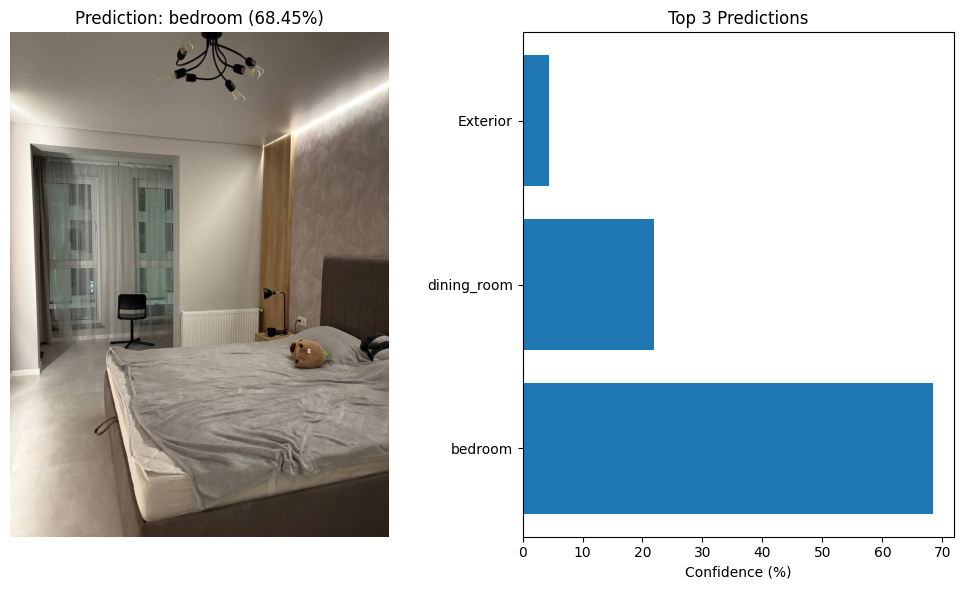

Predicted room type: bedroom with 68.45% confidence

Top 3 predictions:
- bedroom: 68.45%
- dining_room: 21.87%
- Exterior: 4.44%


In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import models
import torch.nn as nn

def load_model(model_path, num_classes):
    """Load the trained ResNet model."""
    model = models.resnet50(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    
    return model

def predict_image(image_path, model, class_names):
    """Make prediction on a single image."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  
    
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probability = torch.nn.functional.softmax(outputs, dim=1)[0]
    
    prediction_idx = predicted.item()
    prediction_class = class_names[prediction_idx]
    confidence = probability[prediction_idx].item() * 100
    
    top3_prob, top3_idx = torch.topk(probability, 3)
    top3_classes = [(class_names[idx], prob.item() * 100) for idx, prob in zip(top3_idx, top3_prob)]
    
    return prediction_class, confidence, top3_classes, image

def main():
    # Configuration
    model_path = 'best_model.pth'  # Path to your trained model
    test_image_path = 'bedroom.jpg'  # Path to image you want to classify
    
    class_names = ['Exterior', 'Interior', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room'] # Replace with your classes
    
    # Load the model
    model = load_model(model_path, len(class_names))
    
    # Make prediction
    prediction, confidence, top3, image = predict_image(test_image_path, model, class_names)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Prediction: {prediction} ({confidence:.2f}%)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    classes = [cls for cls, _ in top3]
    scores = [score for _, score in top3]
    y_pos = range(len(classes))
    
    plt.barh(y_pos, scores, align='center')
    plt.yticks(y_pos, classes)
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    
    plt.tight_layout()
    plt.savefig('prediction_result.png')
    plt.show()
    
    print(f'Predicted room type: {prediction} with {confidence:.2f}% confidence')
    print('\nTop 3 predictions:')
    for cls, score in top3:
        print(f'- {cls}: {score:.2f}%')

def batch_predict(folder_path, model, class_names):
    """Make predictions on all images in a folder."""
    results = []
    
    for filename in os.listdir(folder_path)[:20]:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            prediction, confidence, _, _ = predict_image(image_path, model, class_names)
            results.append((filename, prediction, confidence))
    
    print("\nBatch Prediction Results:")
    print("-" * 50)
    print(f"{'Filename':<30} {'Prediction':<15} {'Confidence':<10}")
    print("-" * 50)
    for filename, pred, conf in results:
        print(f"{filename:<30} {pred:<15} {conf:.2f}%")

if __name__ == '__main__':
    main()
    
    # If you want to run batch prediction on a folder of images, uncomment these lines:
    # class_names = ['Exterior', 'Interior', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']  # Replace with your classes
    # model = load_model('best_model.pth', len(class_names))
    # batch_predict('room_dataset/val/bedroom', model, class_names)